In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import math

from torch.autograd import Variable

import numpy as np

In [2]:
data_path = "drive/MyDrive/Food Images - 128/food-images.npz"
data = np.load(data_path)

In [99]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

## Generator Model

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt['img_size'] // 4
        self.l1 = nn.Sequential(nn.Linear(opt['latent_dim'], 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt['channels'], 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

## Discriminator Model

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt['channels'], 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt['img_size'] // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


class Dataloader:
    def __init__(self, dataset: np.lib.npyio.NpzFile):
        self.dataset = dataset
        self.filelist = dataset.files
    
    def __len__(self):
        return math.floor(len(self.filelist) / 20)

    def __getitem__(self, idx):
        d = torch.from_numpy(self.dataset[self.filelist[idx]])
        if(len(d.size()) != 3):
            d = d.unsqueeze(-1)
            d = torch.squeeze(torch.stack((d, d, d), dim = 2), 3)
        return d.permute(2, 0, 1)

[Epoch 0/1]	[Batch 0/78]	[D loss: 0.693127]	[G loss: 0.688449]


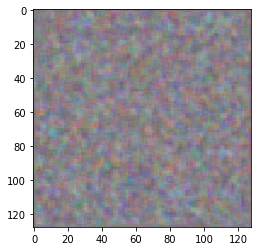

[Epoch 0/1]	[Batch 10/78]	[D loss: 0.693586]	[G loss: 0.690254]
[Epoch 0/1]	[Batch 20/78]	[D loss: 0.693734]	[G loss: 0.691677]
[Epoch 0/1]	[Batch 30/78]	[D loss: 0.693594]	[G loss: 0.692672]
[Epoch 0/1]	[Batch 40/78]	[D loss: 0.693533]	[G loss: 0.692878]
[Epoch 0/1]	[Batch 50/78]	[D loss: 0.693456]	[G loss: 0.692857]


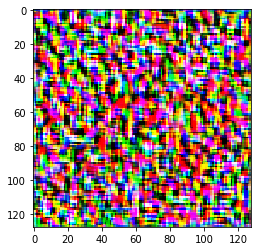

[Epoch 0/1]	[Batch 60/78]	[D loss: 0.693458]	[G loss: 0.692762]
[Epoch 0/1]	[Batch 70/78]	[D loss: 0.693382]	[G loss: 0.692917]


In [104]:
opt = {
    "n_epochs": 1,
    "batch_size": 64,
    "lr_g": 0.001,
    "lr_d": 0.0001,
    "b1": 0.5,
    "b2":0.999,
    "latent_dim": 500,
    "img_size": 128,
    "channels": 3,
    "sample_interval": 400
}

cuda = True if torch.cuda.is_available() else False
# Set the GPU of the model.

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

adversarial_loss = nn.BCELoss()

# Make Models.
generator = Generator()
discriminator = Discriminator()

# Convert to CUDA if available
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    adversarial_loss = adversarial_loss.cuda()

# Apply weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Initialize optimizers.
opt_g = optim.Adam(generator.parameters(), lr = opt['lr_g'], betas = (opt['b1'], opt['b2']))
opt_d = optim.Adam(discriminator.parameters(), lr = opt['lr_d'], betas = (opt['b1'], opt['b2']))

dataloader = torch.utils.data.DataLoader(Dataloader(data), batch_size=opt['batch_size'], shuffle=False, drop_last=True)

for epoch in range(opt['n_epochs']):
    for idx, images in enumerate(dataloader):

        # Create the True/False Identifiers for Discriminator
        valid = Variable(Tensor(images.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(images.shape[0], 1).fill_(0.0), requires_grad=False)

        real_imgs = Variable(images.type(Tensor)) / 255.0 - 0.5

        opt_g.zero_grad()
    
        # Generate Images.
        z = Variable(Tensor(np.random.normal(0, 1, (images.shape[0], opt['latent_dim']))))
        gen_imgs = generator(z)

        # Train the Generator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        opt_g.step()

        # Train the Discriminator
        opt_d.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        opt_d.step()

        if idx % 10 == 0:
            print(
                "[Epoch %d/%d]\t[Batch %d/%d]\t[D loss: %f]\t[G loss: %f]"
                % (epoch, opt['n_epochs'], idx, len(dataloader), d_loss.item(), g_loss.item())
            )
        if idx % 50 == 0:
            z_temp = Tensor(np.random.normal(0, 1, (1, opt['latent_dim'])))
            a = generator(z_temp).permute(0, 2, 3, 1).cpu().detach().numpy()
            a = (a[0] / 2) + 0.5

            %matplotlib inline
            import matplotlib.pyplot as plt
            plt.imshow(a, interpolation='nearest')
            plt.show()

8.940697e-08
0.99999934


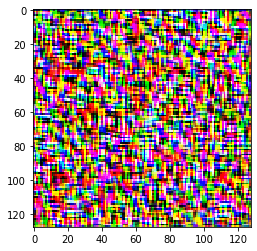

In [105]:
z = Variable(Tensor(np.random.normal(0, 1, (1, opt['latent_dim']))))
a = generator(z).permute(0, 2, 3, 1).cpu().detach().numpy()
a = (a[0] / 2) + 0.5
print(np.min(a))
print(np.max(a))

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(a, interpolation='nearest')
plt.show()